Let's begin by importing the packages we will be using throughout this kernel.

In [2]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
#import tensorflow_addons as tfa
from tensorflow.python.framework import ops
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import cv2
#%matplotlib inline
import os
print(os.listdir("../input"))

['Sign-language-digits-dataset']


Step 1) Observing our data
Let's start off by taking a look at the structure of our data. This will involve the following steps:

i) Loading the database of images into a Numpy array. The data consists of 2062, 64x64 pixel images of sign-language representations of digits 0-9, which we will represent in a vector of pixel densities.

ii) Look at the structure of our pixel matrices. This will allow us to gain a sense of the type of data we will be training our deep neural network with.

iii) Look at a few samples of the images we will be working with.

In [3]:
#Load in our image dataset into a Numpy matrix
Image_path='../input/Sign-language-digits-dataset/X.npy' 
X = np.load(Image_path)
#Load in our classification into a Numpy matrix
label_path='../input/Sign-language-digits-dataset/Y.npy'
Y = np.load(label_path)
#Let's see the dimensions of our pixel matrix and classification matrix
print("Our feature vector is of size: " + str(np.shape(X)))
print("Our classification vector is of size: " + str(np.shape(Y)))

Our feature vector is of size: (2062, 64, 64)
Our classification vector is of size: (2062, 10)


In [4]:
X[0] #Let's see how each image is stored

array([[0.46666667, 0.4745098 , 0.47843137, ..., 0.5176471 , 0.5137255 ,
        0.5019608 ],
       [0.49803922, 0.4862745 , 0.4862745 , ..., 0.5254902 , 0.5176471 ,
        0.50980395],
       [0.54509807, 0.49411765, 0.49019608, ..., 0.5294118 , 0.5254902 ,
        0.5137255 ],
       ...,
       [0.5019608 , 0.5137255 , 0.5176471 , ..., 0.5529412 , 0.54509807,
        0.53333336],
       [0.49803922, 0.5058824 , 0.5137255 , ..., 0.54509807, 0.53333336,
        0.52156866],
       [0.49019608, 0.49803922, 0.5019608 , ..., 0.5294118 , 0.52156866,
        0.50980395]], dtype=float32)

Sample images from dataset (this is 9 in sign language):


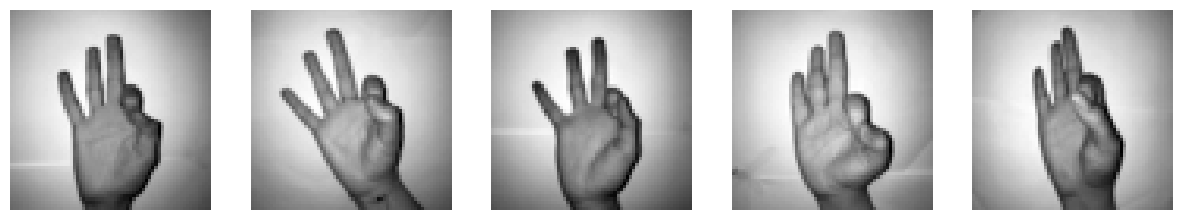

In [5]:
#Let's plot a few sample images, so we have a good sense of the type of images we are feeding into our training algorithm.
print('Sample images from dataset (this is 9 in sign language):')
n = 5
plt.figure(figsize=(15,15))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X[i])
    plt.gray()
    plt.axis('off')

Step 2) Splitting and massaging our data
Let's split and massage our data to prepare it for our deep learning model.

i) let's split our data into two sets - a training set and a test set. Our training set will be used to train our deep learning model. Our test set will be used to test it's accuracy. We'll use sklearn to split our data quickly and efficiently, in a random shuffle. 2/3 of our dataset will be used to train our model, and the remaining 1/3 will be used for testing.

ii) Now, we must flatten our data. Notice how our data has dimensions ( X , Y , Z ). We would like to reduce the dimensionality to ( X , Y ).

In [6]:
#Let's split our data into test/training sets
#We'll use ~2/3 for training and the remaining 1/3 for testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)

print("Training set feature matrix shape: " + str(X_train.shape))
print("Training set classification matrix shape: " + str(Y_train.shape))
print("Testing set feature matrix shape: " + str(X_test.shape))
print("Testing set classification matrix shape: " + str(Y_test.shape))

Training set feature matrix shape: (1381, 64, 64)
Training set classification matrix shape: (1381, 10)
Testing set feature matrix shape: (681, 64, 64)
Testing set classification matrix shape: (681, 10)


In [7]:
#Flatten our data
X_train_flat = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]).T #Flatten our data and transpose ~ (64*64,1381)
X_test_flat = X_test.reshape(X_test.shape[0],X_train.shape[1]*X_train.shape[2]).T #Flatten our data and transpose ~ (64*64,681)
Y_train = Y_train.T
Y_test = Y_test
print(str(X_train_flat.shape))
print(str(Y_train.shape))
print(str(X_test_flat.shape))
print(str(Y_test.shape))

(4096, 1381)
(10, 1381)
(4096, 681)
(681, 10)


Step 3) Setting up the deep neural net using Tensorflow
Our data is ready to be implemented into our model. We will be building a three layer neural network with 25 nodes in the first layer, 15 in the second, and 10 in the output layer (as a result of this being a multiclass classification problem - the images can represent any of the 0-9 digits).

Let's carry out the following steps to implement our deep learning model:

i) Set up Tensorflow placeholder variables to be used later in our neural network as the train/test input matrices and classification matrices

ii) Initialize our weight parameters using Xavier initialiation, and our intercept parameters as a vector of 0's

iii) Define our forward propogation algorithm

iv) Define our cost function and add regularization factors to it

v) Bring all of the above together to create our model

In [8]:
#Let's create some tensorflow place holder values to be used in our model later.
def create_placeholders(n_x, n_y):
    
    X = tf.compat.v1.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.compat.v1.placeholder(tf.float32, [n_y, None], name="Y")
    
    return X, Y

In [9]:
#Let's initialize the parameters to be used in our neural network
print(tf.__version__)

#tf.config.experimental_connect_to_host('grpc://' + os.environ['COLAB_TPU_ADDR'])
#resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
#tf.tpu.experimental.initialize_tpu_system(resolver)
#strategy = tf.distribute.experimental.TPUStrategy(resolver) 
#slim = tf.contrib.slim

def initialize_params():
    
    W1 = tf.compat.v1.get_variable("W1",[25,4096],initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform")) #We will be using Xavier initialization for our weight parameters
    b1 = tf.compat.v1.get_variable("b1",[25,1],initializer=tf.compat.v1.zeros_initializer()) #We will be using a zero vector for our intercept parameter initialization
    W2 = tf.compat.v1.get_variable("W2",[15,25],initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    b2 = tf.compat.v1.get_variable("b2",[15,1],initializer=tf.compat.v1.zeros_initializer())
    W3 = tf.compat.v1.get_variable("W3",[10,15],initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    b3 = tf.compat.v1.get_variable("b3",[10,1],initializer=tf.compat.v1.zeros_initializer())
    
    #Create a dictionary of our parameters to be used in forward propogation
    parameters = {"W1": W1,
                 "W2": W2,
                 "W3": W3,
                 "b1": b1,
                 "b2": b2,
                 "b3": b3}
    
    return parameters

2.11.0


In [10]:
#Define our forward propogation algorithm
def forward_prop(X,parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.tanh(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.tanh(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    return Z3

In [11]:
#Define our cost function
def cost_calc(Z3,Y,parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    
    logits = tf.transpose(a=Z3)
    labels = tf.transpose(a=Y)
    
    cost = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(logits = logits,labels = tf.stop_gradient( labels)) + 0.001*(tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)))
    
    return cost

Step 4) Create our deep learning model
We now have all of the components of our model set up. Let's bring it all together and construct our deep learning model in the following steps

Call our placeholder function
Call our parameter initialization function
Call our forward propagation algorithm and store it in variable Z3
Call our cost function
Define our optimization algorithm. We will be using an Adam optimizer to train our parameters
Run 2000 iterations of our algorithm to effectively train our parameters

In [12]:
#Define our neural network model
def neural_net(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001):

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train_flat.shape                     # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create our placeholder variables of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize our parameters
    parameters = initialize_params()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_prop(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = cost_calc(Z3, Y,parameters)
    
    # Backpropagation: We will be using an Adam optimizer for our backward propogation algorithm
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.compat.v1.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.compat.v1.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        #Loop through 2000 iterations of our Adam optimizer to determine optimal parameters
        for i in range (1,2000):   
            a,b = sess.run([optimizer,cost],feed_dict={X: X_train, Y: Y_train})
            costs.append(b)
            
        parameters = sess.run(parameters)
        print ("Parameters have been optimized.")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(input=Z3), tf.argmax(input=Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    return parameters

Step 5) Run our model, test the results
Our model is complete! Let's run our model and analyze it in the following steps:

Check accuracy on the training set
Check accuracy on the cross-validation set
Plot out cost function as a function of iterations to be sure our algorithm is performing as intended. This should be consistently decreasing.

Parameters have been optimized.
Train Accuracy: 0.98841417
Test Accuracy: 0.75770926


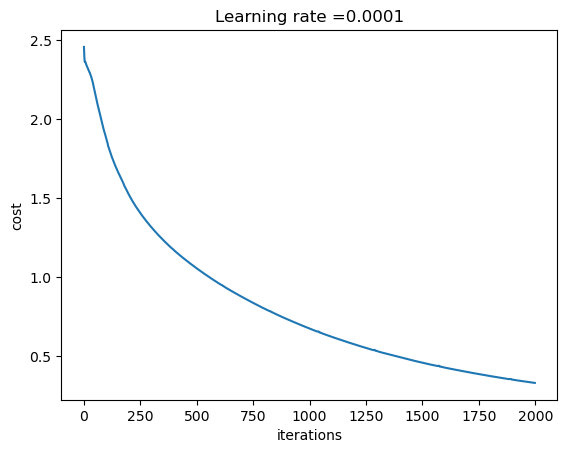

In [15]:
parameters = neural_net(X_train_flat, Y_train, X_test_flat, Y_test.T, learning_rate = 0.0001)

Here's the 50th example in our test set.  This is sign-language for 0.
The classification vector associated with this image is: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
This is what our model should predict when we input this image.


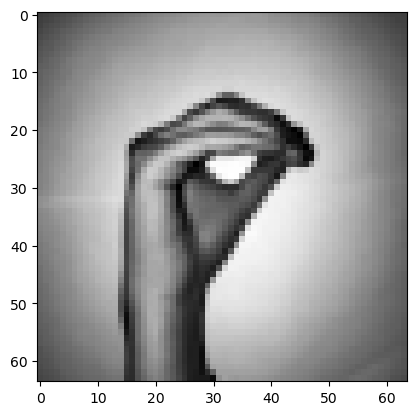

In [16]:
X_single_test = X_test[50] #Let's use the 50th image in our test set for our individual example.
Y_single_test = Y_test[50]
print("Here's the 50th example in our test set.  This is sign-language for 0.")
plt.imshow(X_single_test)
print("The classification vector associated with this image is: " + str(Y_single_test))
print("This is what our model should predict when we input this image.")

Now we know what our output from the neural network should be - a 1x10 zeros with a 1 in the third column. This represents a 0 in sign language (the classification vectors from the dataset are out of order. It would have been cleaner to have made the 50th entry in the classification vector represent a 0, for example)

Let's take the sigmoid of our Z3 vector, set the maximum entry equal to 1, and the other entries equal to 0. Recall that the outputs of our sigmoid function here are essentially "probabilities" of what our image represents. E.g. is Z3[0] = 50%, there is a 50% chance that the image is a zero in sign language.

In [17]:
X_single_test_flat = X_test_flat[:,50:51]
Z3 = forward_prop(X_single_test_flat, parameters)
init = tf.compat.v1.global_variables_initializer()
with tf.compat.v1.Session() as sess:
    sess.run(init)
    a = sess.run(tf.compat.v1.sigmoid(Z3)) #We'll take the max of the sigmoid of the output vector to determine the prediction
z = 1*(a == np.max(a))
z.T
if int(z[1]) == 1:
    print("The image shows a 0 in sign language")
elif int(z[4]) == 1:
    print("The image shows a 1 in sign language")
elif int(z[8]) == 1:
    print("The image shows a 2 in sign language")
elif int(z[7]) == 1:
    print("The image shows a 3 in sign language")
elif int(z[6]) == 1:
    print("The image shows a 4 in sign language")
elif int(z[9]) == 1:
    print("The image shows a 5 in sign language")
elif int(z[3]) == 1:
    print("The image shows a 6 in sign language")
elif int(z[2]) == 1:
    print("The image represents a 7 in sign-language")
elif int(z[5]) == 1:
    print("The image shows a 8 in sign language")
elif int(z[0]) == 1:
    print("The image shows a 9 in sign language")
else:
    print("Unidentifiable. Please try another input.")

The image shows a 0 in sign language


Our output vector is the same, and our neural network has accurately predicted what the image represents!

This concludes the kernel.